# HW5: Topic Models and LDA


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Spring, 2021._

---

**Name:** Eric Weiner

**Names of any collaborators:** _Names here_

*Due: 11:59pm Monday, May 10, 2021 via GradeScope*

---

Recall the following generative model for LDA. Suppose we have $K$ topics and $N$ documents.

For each topic $k \leq K$, draw a topic 
$$\eta_k \sim \text{Dir}(\phi)$$

Then, for each document $n \leq N$, draw topic proportions 
$$\pi_n \sim \text{Dir}(\alpha)$$

Finally, for each word $l$ in document $n$, first draw a topic assignment 
$$
z_{n,l} \mid \pi_n \sim \text{Cat}(\pi_n)
$$
and draw a word
$$
x_{n,l} \mid z_{n,l} \sim \text{Cat}(z_{n,l})
$$

As mentioned in class, while this formulation is easier to present, it's more efficient to represent the documents as sparse vectors of _word counts_, $\mathbf{y}_n \in \mathbb{N}^V$ where $y_{n,v} = \sum_{l=1}^L \mathbb{I}[x_{n,l} = v]$. 

In this assignment, we will be re-exploring the Federalist papers in their entirety. We've provided a $N \times V$ dataframe of the essays represented as word counts. The rows of the data frame correspond to the 85 individual essays and the columns correspond to the 5320 words in the vocabulary. We have already preprocessed the raw essays to remove very common and very infrequent words.

Using this data, we will fit a topic model and do some analysis.

In [8]:
import pandas as pd 

# Load the data
df = pd.read_csv('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 5/tokenized_fed.csv', index_col = 0)
type(df['unequivocal'][0])

numpy.float64

## Problem 1: Fit LDA on this data set.

Fit a 10 topic LDA on the data using CAVI. For each topic, output the top 5 words. You might find the structure in the [Poisson matrix factorization notebook](https://github.com/slinderman/stats271sp2021/blob/main/notebooks/Lap_5_Poisson_MF.ipynb) helpful. (Note that that notebook used the JAX backend available in the `tfp-nightly` package, but you could have used the regular [TensorFlow Probability](tensorflow.org/probability/api_docs/python/tfp) package instead. The nice thing about TFP is that its functions broadcast nicely, which is helpful when we have lots of factors in the mean field variational posterior.

In [363]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

from jax import jit
import jax.numpy as np
import jax.scipy.special as spsp
import jax.random as jr

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as tfd

from numpy.random import seed
from numpy.random import rand

import tensorflow as tf

In [370]:
#df = df.to_numpy()


def dir_exp_log(dirichlet):
        return np.asarray(np.exp(spsp.digamma(np.asarray(dirichlet.concentration)) - \
                                 spsp.digamma(np.sum(np.asarray(dirichlet.concentration)))))
    
def cavi_step(q_pi, q_eta):
    
    def assignment_lambdas(pis, etas):
            update_lambdas = dir_exp_log(pis)[:, None, :] +  dir_exp_log(etas)
            return update_lambdas 

    def pi_lambdas(qz):
            #full_array = data@np.asarray(qz.probs_parameter())
            #diag_arr = np.diagonal(full_array, axis1 = 0, axis2 = 1).T
            new = qz.mean().sum(axis =1)
            return alphas + new

    #print(type(pi_lambdas()    
    def eta_lambdas(qz):
            #matrix_to_use = np.reshape(np.asarray(qz.probs_parameter()),(5320,85,10))
            #full_array = data.T@matrix_to_use
            #diag_arr = np.diagonal(full_array, axis1 = 0, axis2 = 1).T
            new = qz.mean().sum(axis =0)
            return phis + new
    
    #print(type(df))
    #print(type(assignment_lambdas(q_pi, q_eta)))
    
    q_z = tfd.Multinomial(df, probs = assignment_lambdas(q_pi,q_eta))
    
    new_pi_lambdas = pi_lambdas(q_z)
    q_pi = tfd.Dirichlet(new_pi_lambdas)

    new_eta_lambdas = eta_lambdas(q_z)
    q_eta = tfd.Dirichlet(new_eta_lambdas)
        
    return q_z, q_pi, q_eta  

def elbo(q_z, q_pi, q_eta):

    elbo = 0
    div_pi = q_pi.kl_divergence(q_pi_prior).sum()
    elbo -= div_pi
    #print(f"the div pi is: {div_pi}")
    div_eta = q_eta.kl_divergence(q_eta_prior).sum()
    elbo -= div_eta
    #print(f"the div eta is: {div_eta}")
    mid_term_1 = (q_z.probs_parameter()*dir_exp_log(q_pi)[:,None,:]).sum()
    elbo += mid_term_1
    #print(f"the mid term 1 is: {mid_term_1}")
    mid_term_2 = (q_z.probs_parameter()*dir_exp_log(q_eta)[None,:,:]).sum()
    #print(f"the mid term 2 is: {mid_term_2}")
    elbo += mid_term_2
    last_term = (q_z.mean()*np.log(q_z.probs_parameter())).sum()
   
    #print(f"the last term is: {last_term}")
   
    elbo -= last_term
    #elbo -= (q_z.mean()*np.log(q_z.probs_parameter())).sum()
    return elbo/np.sum(df) 


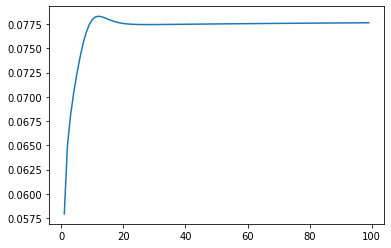

In [371]:
### CAVI DO NOT DELETE
def cavi(data, num_iters):
    data = data.astype(onp.float32)
    N = 85
    V = 5320
    K = 10
    
    alphas = np.ones((N, K))
    phis = np.ones((V, K))
    
    data = data.astype(np.float32)


    q_pi_prior = tfd.Dirichlet(alphas)
    random_alphas = np.multiply(np.reshape(rand(N*K),(N,K)), alphas)
    q_pi = tfd.Dirichlet(random_alphas)
    
    q_eta_prior = tfd.Dirichlet(phis)
    random_phis = np.multiply(np.reshape(rand(V*K),(V,K)), phis)
    q_eta = tfd.Dirichlet(random_phis)
    
    elbos = []
    for itr in trange(num_iters):
        q_z, q_pi, q_eta = cavi_step(q_pi, q_eta)
        elbo_iter =  elbo(q_z, q_pi, q_eta)
        elbos.append(elbo_iter)
    return np.asarray(elbos), (q_z, q_pi, q_eta)


elbos_graphing, approxes = cavi(df, 100)
plt.plot(elbos_graphing)


In [431]:
df_to_map = pd.read_csv('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 5/tokenized_fed.csv', index_col = 0)

def top_words(t):
    maxes = np.sort(q_eta.concentration[:,t], axis = 0)[-5:]
    indeces = []
    for i in range(5):
        index = np.where(q_eta.concentration[:,t] == maxes[i])
        indeces.append(np.asarray(index))
    
    for i in range(len(np.asarray(indeces))):
        print(f"The {5-i} th highest word in topic {t+1} is {df_to_map.columns[indeces[i]]}")

        
for t in range(10):
    top_words(t)

The 5 th highest word in topic 1 is Index(['oppress'], dtype='object')
The 4 th highest word in topic 1 is Index(['divisions'], dtype='object')
The 3 th highest word in topic 1 is Index(['creation'], dtype='object')
The 2 th highest word in topic 1 is Index(['peremptory'], dtype='object')
The 1 th highest word in topic 1 is Index(['pristine'], dtype='object')
The 5 th highest word in topic 2 is Index(['phantom'], dtype='object')
The 4 th highest word in topic 2 is Index(['future'], dtype='object')
The 3 th highest word in topic 2 is Index(['paramount'], dtype='object')
The 2 th highest word in topic 2 is Index(['overlooked'], dtype='object')
The 1 th highest word in topic 2 is Index(['manufacturing'], dtype='object')
The 5 th highest word in topic 3 is Index(['overlooked'], dtype='object')
The 4 th highest word in topic 3 is Index(['succor'], dtype='object')
The 3 th highest word in topic 3 is Index(['deserves'], dtype='object')
The 2 th highest word in topic 3 is Index(['insignificanc

## Problem 2: Analysis/Exploration

Using the model, for each essay assign it the most likely topic. For the undisputed papers, plot the histogram of this topic usage vs author.

In [415]:
#load authorship
authorship = pd.read_csv('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 5/authorship.csv', index_col = 0)

In [465]:
#df_to_map = pd.read_csv('/Users/ericgarc/Desktop/Stanford/Spring 2021/STATS 271/HW 5/tokenized_fed.csv', index_col = 0)
topics = []
def top_topic(n):
    max = np.sort(q_pi.concentration[n,:])[-1]
    index = np.asarray(np.where(q_pi.concentration[n,:] == max))
    #print(f"Document {n+1} belongs to topic {index}")
    return index
        
for n in range(85):
    topics.append(top_topic(n))

    
topics = np.squeeze(np.asarray(topics), axis=2)   


Text(0, 0.5, 'Frequency')

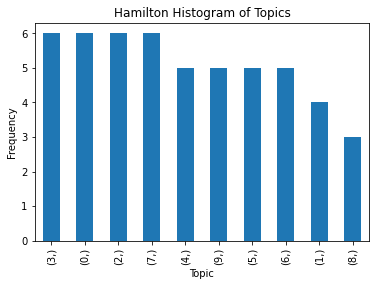

In [462]:
new_auth = authorship.to_numpy()
authorship['Topic'] = topics
auth_nodis = authorship.loc[authorship['x'] != 'DISPUTED']
hamilton = authorship.loc[authorship['x'] == 'HAMILTON']
jay = authorship.loc[authorship['x'] == 'JAY']
madison = authorship.loc[authorship['x'] == 'MADISON']

hamilton['Topic'].value_counts().plot(kind = "bar")
plt.title("Hamilton Histogram of Topics")
plt.xlabel('Topic')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

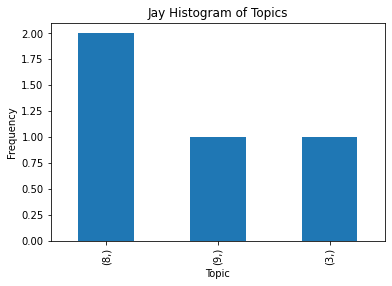

In [463]:
jay['Topic'].value_counts().plot(kind = "bar")
plt.title("Jay Histogram of Topics")
plt.xlabel('Topic')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

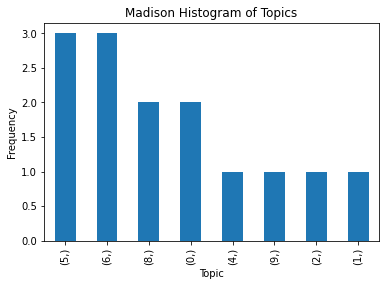

In [464]:
madison['Topic'].value_counts().plot(kind = "bar")
plt.title("Madison Histogram of Topics")
plt.xlabel('Topic')
plt.ylabel('Frequency')

## Problem 3: Short Answer questions

### Part a)

Explain what approach you would take if you wanted to use LDA to help settle disputed authorship. How would you incorporate authorship by different authors into your model?

### Part b)

A shortcoming of LDA discussed in this class is the fact that the model is exchangeable (which is not a very reasonable assumption for essays). What would you do to address this shortcoming? In essence, how could you account for dependencies between words that are near each other in the essay?

### Part (a) answer:

First, I would take out all of the papers that were disputed before training the LDA model. We could then propose a new latent variable that would assign a document to a specific author. We could then use LDA with two latent variables: document assignment to topic and document assignment to author. This would be very similar to what we have just done except we would now be approximating for factorized posteriors. However, this might start to break down as the independence assumption might not start to hold anymore.

### Part (b) answer:

To address the exchangeability issue, we could create two (or more) dictionaries that contain single words, a string of two words, strings of three words, etc. We could then conduct LDA on all of the dictionaries separately and compare the assignment of topics to the one-word, two-word, three-word, etc. dictionaries. 

Alternatively, we could search for unique strings in the authored papers that occur more frequently for certain authors. We could then create dictionaries for those unique strings and run LDA with a certain number of topics. However, if we are looking for strings of words and not just words, we should not exclude frequent "filler" words or words that occur very infrequently as the construction of phrases using these words could be unique to authors.

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw5_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
